<a href="https://colab.research.google.com/github/chiroiu96/NeuralStyle/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional Neural Networks

In [1]:
#@title Simple CNN
from IPython.display import Image
Image(url='https://www.researchgate.net/publication/335086346/figure/fig3/AS:790156168687616@1565399319399/Basic-architecture-of-CNN.ppm')

In [2]:
#@title Convolution operation
from IPython.display import Image
Image(url='https://miro.medium.com/max/3000/1*GcI7G-JLAQiEoCON7xFbhg.gif')

In [3]:
#@title Pooling
from IPython.display import Image
Image(url='https://www.researchgate.net/publication/333593451/figure/fig2/AS:765890261966848@1559613876098/Illustration-of-Max-Pooling-and-Average-Pooling-Figure-2-above-shows-an-example-of-max.png')

In [4]:
#@title CNN Layers Visualization
from IPython.display import Image
Image(url='https://www.kindpng.com/picc/m/605-6056721_visualizing-and-understanding-convolutional-networks-cnn-visualize-hidden.png')

In [5]:
#@title Neural Style Transfer
from IPython.display import Image
Image(url='https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization_files/output_OEAPEdq698gs_0.png')

###Necessary imports

In [6]:
import IPython.display as display
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

###Helper functions



In [7]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

content_image = None

In [8]:
#@title 2. Choose a style image from the options below 🎆

STYLE_IMAGE_NAME = 'IMAGE_1' #@param ['IMAGE_1', 'IMAGE_2', 'IMAGE_3', 'IMAGE_4', 'IMAGE_5']

corresponding_url = {
    'IMAGE_1': 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
    'IMAGE_2': 'https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg',
    'IMAGE_3': 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/1024px-Tsunami_by_hokusai_19th_century.jpg',
    'IMAGE_4': 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg/800px-Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
    'IMAGE_5': 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/757px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'
}

style_image_path = tf.keras.utils.get_file(STYLE_IMAGE_NAME + ".jpg", corresponding_url[STYLE_IMAGE_NAME])
print("Style image downloaded!")

204800/195196 [===============================] - 0s 0us/step
Style image downloaded!


<center><img src = 'https://i.ibb.co/Tmnwnbc/Untitled-Diagram.png'></img></center>

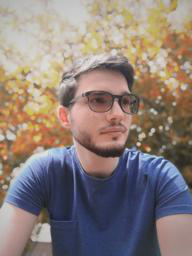

In [10]:
#@title 3. Upload an image you want to stylize 🖼
import ipywidgets as widgets
import io
from IPython.display import clear_output
from PIL import Image

clear_output()

def button_click(change):
    global content_image
    print('\n')
    img = Image.open(io.BytesIO(uploader.data[-1]))
    content_image = img
    img = img.convert('RGB')
    img.thumbnail((256, 256))
    img.save('thumbnail.jpg')
    image = Image.open('thumbnail.jpg')
    display.display(image)
    
uploader = widgets.FileUpload()
show_button = widgets.Button(description='Show image')
show_button.on_click(button_click)

widgets.VBox([widgets.Label('Upload a content image (must be an RGB or RGBA image). High-res images might take more time to be processed.'), uploader, show_button])

In [ ]:
#@title [Optional] You can also use your Webcam! 📸
#@markdown Just execute this cell and click anywhere in the streaming feed.

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
    global content_image
    display.display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])
    f = io.BytesIO(binary)
    content_image = Image.open(f)
    print('\nImage captured! 🤳')

take_photo()


Image captured! 🤳


In [11]:
#@title Load images
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def load_content_img(image_pixels):
    max_dim = 512
    if image_pixels.shape[-1] == 4:
        image_pixels = Image.fromarray(image_pixels)
        img = image_pixels.convert('RGB')
        img = np.array(img)
        img = tf.convert_to_tensor(img)
        img = tf.image.convert_image_dtype(img, tf.float32)
        shape = tf.cast(tf.shape(img)[:-1], tf.float32)
        long_dim = max(shape)
        scale = max_dim / long_dim

        new_shape = tf.cast(shape * scale, tf.int32)

        img = tf.image.resize(img, new_shape)
        img = img[tf.newaxis, :]
        return img
    elif image_pixels.shape[-1] == 3:
        img = tf.convert_to_tensor(image_pixels)
        img = tf.image.convert_image_dtype(img, tf.float32)
        shape = tf.cast(tf.shape(img)[:-1], tf.float32)
        long_dim = max(shape)
        scale = max_dim / long_dim

        new_shape = tf.cast(shape * scale, tf.int32)

        img = tf.image.resize(img, new_shape)
        img = img[tf.newaxis, :]
        return img
    elif image_pixels.shape[-1] == 1:
        raise Error('Grayscale images not supported! Please try with RGB or RGBA images.')
    print('Exception not thrown')

if content_image == None:
  content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
  content_image = load_img(content_path)
else:
  # Convert the content image from Bytes to NumPy array.
  content_image = np.array(content_image)

  # Load the input images.
  content_image = load_content_img(content_image)
style_image = load_img(style_image_path)
print('Images loaded up!')

Images loaded up!


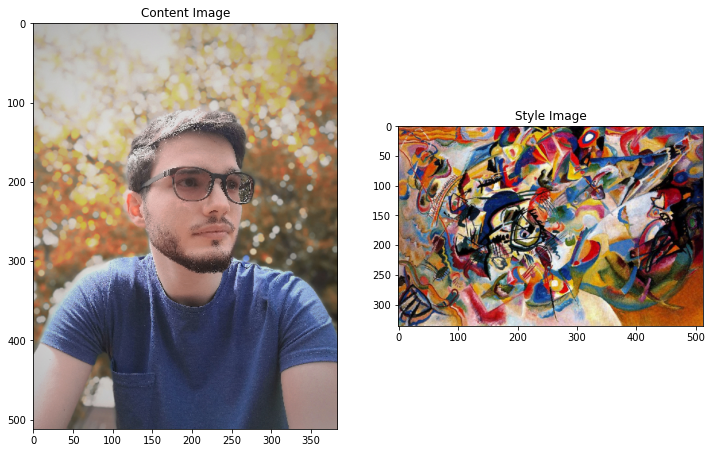

In [12]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

##Neural Style Concept

![picture](https://drive.google.com/uc?export=view&id=1enMz83l7Yut33wR0IOMqLBmMN2JcZCSE)

![picture](https://drive.google.com/uc?export=view&id=1S6XNXrq8_ixHNlxXxJR7G0mddB9LGVFl)

In [29]:
#@title Total loss
from IPython.display import Image
Image(url='https://cdn-images-1.medium.com/max/800/1*JsqfM5hNn3cL9IJbMZR5kg.png')

##Content Loss

![picture](https://drive.google.com/uc?export=view&id=1jiA9BQQlsrIlQ1dG3NqCkrX68U6aOo_K)

##Style Loss

![picture](https://drive.google.com/uc?export=view&id=1ASDmZiEmBWo1zU6bGDSUci5b0llXUFZg)

##Gram matrix

![picture](https://drive.google.com/uc?export=view&id=1mfnEw5M974ROPK9yB0y0bIdOOzxormaY)

##VGG-19 Architecture

![picture](https://drive.google.com/uc?export=view&id=1hKYhCf2a7JsLY1wuy2UI6-I5LQbTxsyw)

In [13]:
#@title VGG-19 Layers
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
print()
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [14]:
#@title Layers selection
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

##Build the model

In [15]:
#@title 
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [16]:
#@title Extract style from style image and content from content image
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

##Run Gradient Descent

In [27]:
#@title Gradient Descent algorithm overview
from IPython.display import Image
Image(url='https://i.ytimg.com/vi/b4Vyma9wPHo/maxresdefault.jpg')

In [17]:
image = tf.Variable(content_image)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

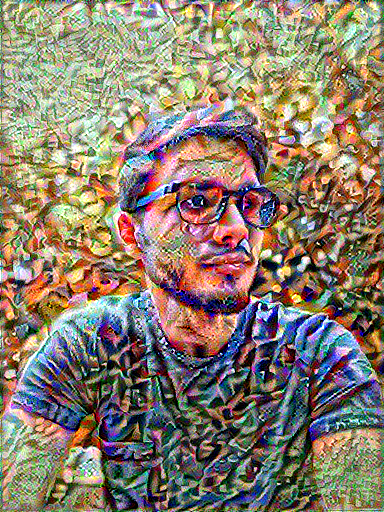

Train step: 100
................................................................

KeyboardInterrupt: ignored

In [28]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

##Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the total variation loss:

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

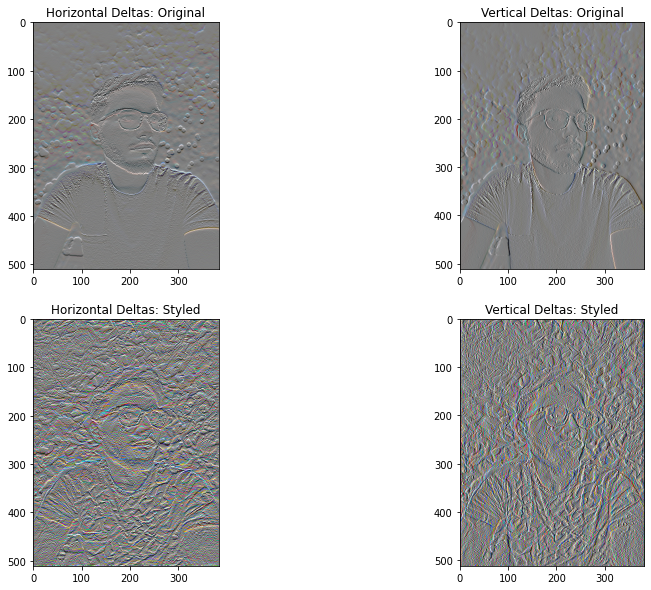

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

This shows how the high frequency components have increased.

Also, this high frequency component is basically an edge-detector.

##Add total variation loss and re-run the optimization

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
image = tf.Variable(content_image)

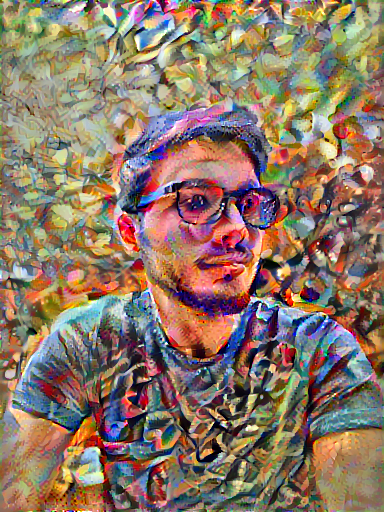

Train step: 1000
Total time: 254.3


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))